# Web Scraping for Indeed.com & Predicting Salaries

## Domain and Data

Job posting data is given from Indeed site after scrapping the data from the website. The data file has job title, location summary and salary information. The majority of the data is pertaining to data scientist role from Indeed.


## Problem Statement

To predict a binary variable - whether the salary was low or high. We will compute the median salary and create a new binary variable that is true when the salary is high (above the median).

We can perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

We will leverage location, title and skills information given. Determine if the salary is low or high and run a logistic regression model. 

## Metric
Baseline Accuracy, R2 (coefficient of determination), Metrics accuracy score

In [169]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd

In [170]:
file_location = "../assets/indeed-scraped-job-postings.csv"
df_job_posting = pd.read_csv(file_location)
df_job_posting.head(5)

city                         company                    salary  \
0  Denver      Department Of The Interior  $76,341 - $99,243 a year   
1  Denver      Department Of The Interior  $71,012 - $99,243 a year   
2  Denver  Mental Health Center of Denver  $70,000 - $80,000 a year   
3  Denver           Denver Public Schools  $62,712 - $75,255 a year   
4  Denver          University of Colorado  $25,000 - $29,000 a year   

                                             summary  \
0  Would you like to join the more than 10,000 sc...   
1  Investigate potential uses of geospatial data ...   
2  Advise the Data Developer with regard to creat...   
3  Portal managers on student outcome data report...   
4  Experience entering and manipulating data in a...   

                                               title  parsed_salary  
0             Statistician, GS-1350-12 (DEU-PERM-DS)        87792.0  
1  Interdisciplinary Cartographer/Geographer - GS...        85127.5  
2                           Financial Data Scientist        75000.0  
3                            SENIOR RESEARCH ANALYST        68983.5  
4                                      Animal Care I        27000.0

### Clean data

This data file has key information as salary, summary, location, parsed_salary. 

1. **`Parsed_salary`** have  7 observations with null value and hence they are dropped.

2. **`City`** column have + as character in some cities and they are replaced with a space.

3. **`Parsed_salary`** seems computed based on salary column and it appears to be mean for the range shown.


In [171]:
df_job_posting.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 6 columns):
city             413 non-null object
company          413 non-null object
salary           413 non-null object
summary          413 non-null object
title            413 non-null object
parsed_salary    406 non-null float64
dtypes: float64(1), object(5)
memory usage: 19.4+ KB


In [172]:
df_job_posting.shape

(413, 6)

In [173]:
# since there are only seven observations with null values in salary we will remove those observations
df_job_posting[df_job_posting['parsed_salary'].isnull()] ## 7 values are missing
df_job_posting.dropna(axis=0, inplace=True)

#df_job_posting[df_job_posting['title'].isnull()] ## no rows with title as null
#df_job_posting[df_job_posting['city'].isnull()] ## no rows with city as null
#df_job_posting[df_job_posting['summary'].isnull()] ## no rows with summary as null

df_job_posting["clean_city"] = df_job_posting["city"].str.replace("+"," ")


## Exploratory Data Analysis and Visualization

In [174]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

1. Describe the parsed_salary and review descriptive statistics
2. Calculate or Get **median salary** and create a variable `salary_flag` that lables 0 for parsed_salary lower then median salary and label 1 for salary higher or equal than median salary.
3. Get the statistics on title and city columns.
4. Plot a bar graph on Salary for each city to quickly review the range for each city.
5. Plot a histogram and review the distribution and shape of the bell curve and identify outliers.
6. Plot a bubble chart to see where the highest number of jobs exists in the given city/location.

7. Utilize Describe, Groupby, Pivot Table, Seaborn and Tablau for visualization.
8. sns.Barplot,sns.distplot, Tablau bubble chart, Group by 


In [175]:
df_job_posting['parsed_salary'].describe()

count       406.000000
mean     107762.695813
std       48931.367632
min       10000.000000
25%       70000.000000
50%      100000.000000
75%      142164.500000
max      300000.000000
Name: parsed_salary, dtype: float64

In [176]:
np.median(df_job_posting['parsed_salary'])

100000.0

In [177]:
df_job_posting[['city','title']].describe()

city           title
count        406             406
unique        18             332
top     New+York  Data Scientist
freq         102              23

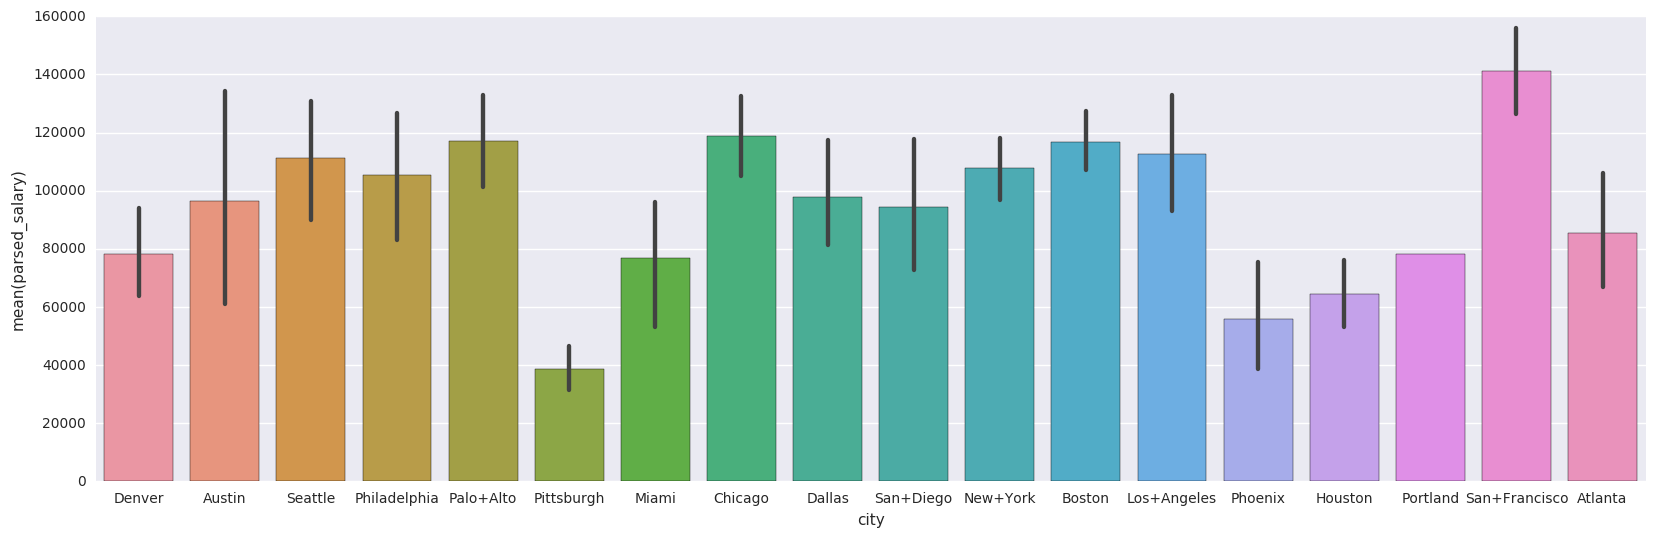

In [178]:
fig = plt.figure(figsize=(20,6)) 
sns.barplot(x="city",y="parsed_salary",data=df_job_posting,label="City")

In [179]:
df_job_posting.groupby("city").sum()

parsed_salary
city                        
Atlanta            1620311.5
Austin              676000.0
Boston             5481887.5
Chicago            4044631.5
Dallas             1175500.0
Denver             1329339.5
Houston             579648.0
Los+Angeles        2590634.0
Miami               460775.0
New+York          11004693.0
Palo+Alto          3166218.0
Philadelphia       1161000.0
Phoenix             334716.5
Pittsburgh          347928.0
Portland             78195.5
San+Diego           944786.0
San+Francisco      6642111.5
Seattle            2113279.0

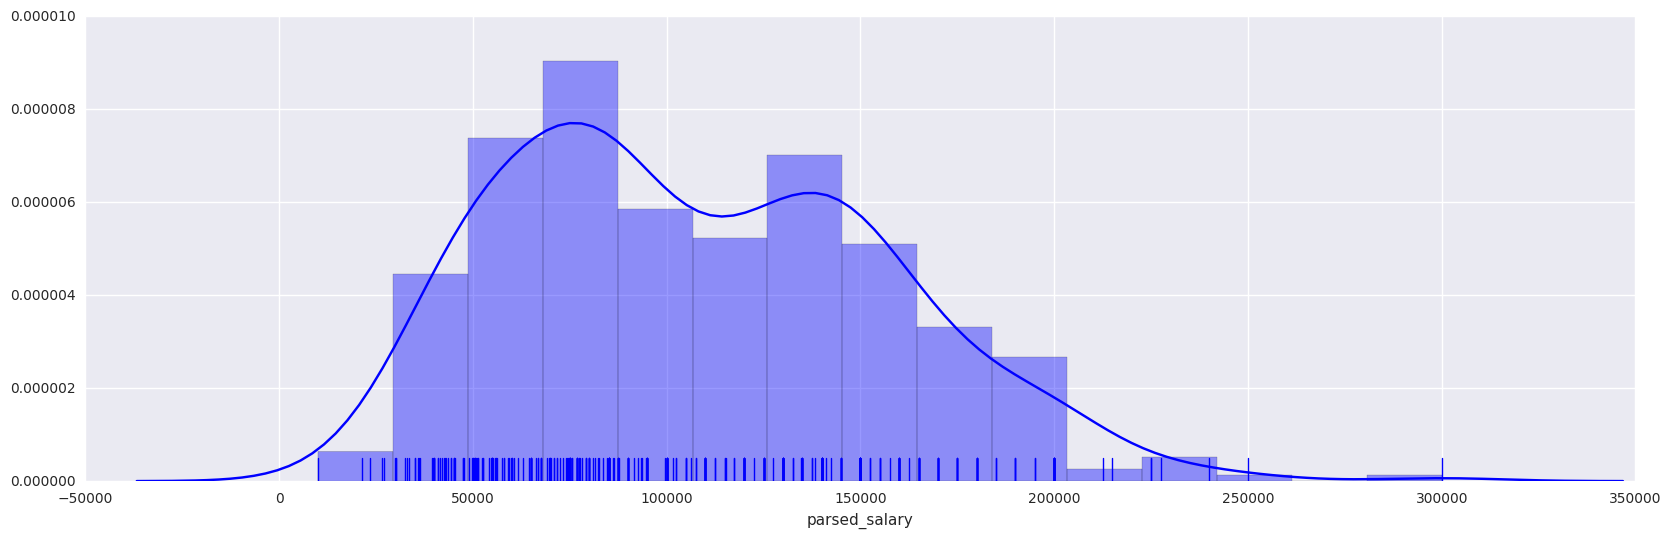

In [180]:
#df_job_posting.hist("parsed_salary", bins=15)
fig = plt.figure(figsize=(20,6)) 
sns.distplot(df_job_posting["parsed_salary"], rug=True, color='b')

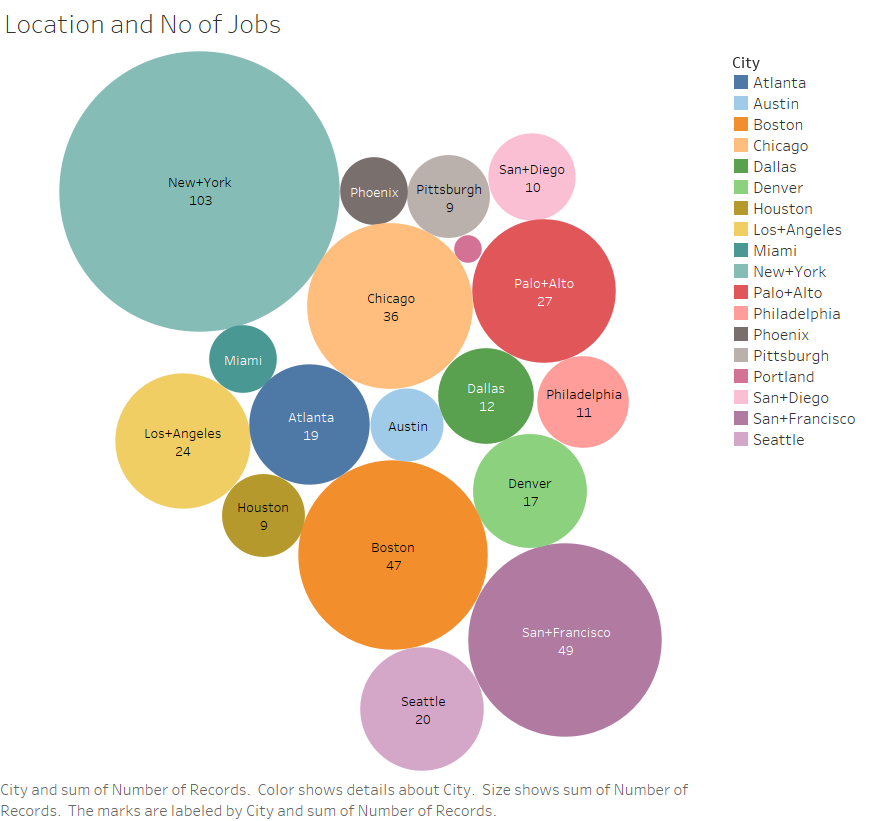

In [181]:
from IPython.display import Image
Image(filename='../assets/images/Jobs_location.png') 

In [182]:
df_job_posting.groupby("city")["parsed_salary"].count()

city
Atlanta           19
Austin             7
Boston            47
Chicago           34
Dallas            12
Denver            17
Houston            9
Los+Angeles       23
Miami              6
New+York         102
Palo+Alto         27
Philadelphia      11
Phoenix            6
Pittsburgh         9
Portland           1
San+Diego         10
San+Francisco     47
Seattle           19
Name: parsed_salary, dtype: int64

## Data Preprocessing

1. Compute the median salary and create salary_flag(binominal) with High/Low as 1 or 0.
2. Create a clean_title column.
3. Streamline title column by parsing and identifying all relevant key words from title column.
4. Leverage all skills in title column and create a column call skilled.
5. Review all highest and lowest salaries and make a deterination as to keep or drop them.
6. Calculate the baseline accuracy score
7. Review newly created title column for its descriptive statistics and approproateness of values.
8. Review newly created skills column for its descriptive statistics and approproateness of values.
9. Create Augumented Feature Data Frame with Cleaned City, Salary_b, Cleaned Title and Skills Features.
10. Remove City, Company, Salary, Title, Summary, parsed_salary columns from features list.
11. Plot bar chart on City over salar_b
12. Get dummy variabes on City, Title and Skills
13. Create X and y for modeling.


In [183]:
median_sal = df_job_posting['parsed_salary'].median()
df_job_posting['salary_flag'] = df_job_posting['parsed_salary']\
            .apply(lambda x: 1 if x >= median_sal else 0) 

In [184]:
df_job_posting["clean_title"]=df_job_posting["title"]
df_job_posting.head()

city                         company                    salary  \
0  Denver      Department Of The Interior  $76,341 - $99,243 a year   
1  Denver      Department Of The Interior  $71,012 - $99,243 a year   
2  Denver  Mental Health Center of Denver  $70,000 - $80,000 a year   
3  Denver           Denver Public Schools  $62,712 - $75,255 a year   
4  Denver          University of Colorado  $25,000 - $29,000 a year   

                                             summary  \
0  Would you like to join the more than 10,000 sc...   
1  Investigate potential uses of geospatial data ...   
2  Advise the Data Developer with regard to creat...   
3  Portal managers on student outcome data report...   
4  Experience entering and manipulating data in a...   

                                               title  parsed_salary  \
0             Statistician, GS-1350-12 (DEU-PERM-DS)        87792.0   
1  Interdisciplinary Cartographer/Geographer - GS...        85127.5   
2                           Financial Data Scientist        75000.0   
3                            SENIOR RESEARCH ANALYST        68983.5   
4                                      Animal Care I        27000.0   

  clean_city  salary_flag                                        clean_title  
0     Denver            0             Statistician, GS-1350-12 (DEU-PERM-DS)  
1     Denver            0  Interdisciplinary Cartographer/Geographer - GS...  
2     Denver            0                           Financial Data Scientist  
3     Denver            0                            SENIOR RESEARCH ANALYST  
4     Denver            0                                      Animal Care I

In [185]:
# #!pip install stop-words
# from stop_words import get_stop_words
# stop_words = get_stop_words('english')

# for row in df_job_posting["summary"]:
#     split_row = row.split()
#     result_words  = [word for word in split_row if word.lower() not in stop_words]
#     result = result + ' '.join(result_words)
# result
# from collections import Counter
# word_counts = Counter(result)
# for word, count in word_counts.most_common(1000):
#     print word, count

In [186]:
# DO NOT remove rows for title that are not relevant
# df_job_posting = df_job_posting[df_job_posting["title"] !='Animal Care I'] # one row removed
# df_job_posting = df_job_posting[df_job_posting["title"] !='CNUP Assistant'] # one row removed
# df_job_posting = df_job_posting[df_job_posting["title"] !='A.I. Psychologist/Research Assistant'] # one row removed
# df_job_posting = df_job_posting[df_job_posting["title"] !='Cytometry Technician'] # one row removed
# df_job_posting = df_job_posting[df_job_posting["title"] !='School Business Manager and Human Resources (HR)'] # one row removed
# df_job_posting = df_job_posting[df_job_posting["title"] !='Account Management'] # one row removed
# df_job_posting = df_job_posting[df_job_posting["title"] !='Accountant, Associate, College of Medicine - Phoenix'] # one row removed
# df_job_posting = df_job_posting[df_job_posting["title"] !='Research Analyst for Tech Industry'] # one row removed
# df_job_posting = df_job_posting[df_job_posting["title"] !='Clinical Laboratory Assistant'] # one row removed
# df_job_posting = df_job_posting[df_job_posting["title"] !='Health Technician (Optometry)'] # one row removed
# df_job_posting = df_job_posting[df_job_posting["title"] !='Post-Doctoral Scholar-Employee: Analysis of omics data'] # one row removed
# df_job_posting = df_job_posting[df_job_posting["title"] !='Realty Specialist'] # one row removed
# df_job_posting = df_job_posting[df_job_posting["title"] !='Web Security Research Analyst'] # one row removed
# df_job_posting = df_job_posting[df_job_posting["title"] !='Real Estate / Title Research Analyst'] # one row removed
# df_job_posting = df_job_posting[df_job_posting["title"] !='Career Coach'] # one row removed
# df_job_posting = df_job_posting[df_job_posting["title"] !='Geologist GS-1350-07/09 (DEU - TERM - JG)'] # one row removed
# df_job_posting = df_job_posting[df_job_posting["title"] !='Career Coach'] # one row removed
# df_job_posting = df_job_posting[df_job_posting["title"] !='Medical Technologist'] # one row removed
# df_job_posting = df_job_posting[df_job_posting["title"] !='PRODUCT DEVELOPMENT SCIENTIST - Flavors'] # one row removed
# df_job_posting = df_job_posting[df_job_posting["title"] !='Systems Programmer'] # one row removed
# df_job_posting = df_job_posting[df_job_posting["title"] !='Clinical Research Scientist'] # one row removed
# df_job_posting = df_job_posting[df_job_posting["title"] !='Certifying Scientist / Toxicologist'] # one row removed
# df_job_posting = df_job_posting[df_job_posting["title"] !='Sr. Certifying Scientist / Toxicologist'] # one row removed
# df_job_posting = df_job_posting[df_job_posting["title"] !='Bioinformatics Postdoctoral Fellow'] # one row removed
# df_job_posting = df_job_posting[df_job_posting["title"] !='Certifying Scientist / Toxicologist'] # one row removed
# df_job_posting = df_job_posting[df_job_posting["title"] !='Sr. Certifying Scientist / Toxicologist'] # one row removed



#df_job_posting[df_job_posting["title"] =='Account Management']

** Calculate the Baseline Accuracy **

**`baseline_accuracy = majority_class_N / total_population`**

In [187]:
df_job_posting.groupby(by="salary_flag").count()

city  company  salary  summary  title  parsed_salary  clean_city  \
salary_flag                                                                     
0             197      197     197      197    197            197         197   
1             209      209     209      209    209            209         209   

             clean_title  
salary_flag               
0                    197  
1                    209

In [188]:
np.mean(df_job_posting["salary_flag"])

0.51477832512315269

In [189]:
baseline_accuracy = 1. - np.mean(df_job_posting["salary_flag"])
baseline_accuracy

0.48522167487684731

### Baseline Accuracy is set to 48.52%: 
** We calculated baseline accuracy based on formula above i.e. We first classified high or low salary based on median salary and then took the majority class over total population**

**Below function will parse title column in to a streamlined few position/titles based on key word. Almost all job titles are labled in a a category few are labled as mics.**

**I seek to leverage titles as a predictor in the model to classify whether based on certain keywords does salary falls in high/low category.**

In [190]:
def parse_title(x):
    x = x.lower()
    if 'vp ' in x or 'vice president' in x:
        return 'Executive'
    elif 'manager' in x or 'director' in x:
        return 'Manager'
    elif 'statistics' in x or 'statistician' in x or 'geographer' in x or 'statistical' in x:
        return 'Statistician'
    elif 'senior' in x or 'sr.' in x or 'analyst iv' in x or 'big data' in x:
        return 'Senior'
    elif 'data scientist' in x or 'data science' in x or 'scientist' in x or \
        'big data' in x or 'analytics' in x or 'python' in x or 'machine learning' in x\
        or 'full stack' in x or 'full - stack' in x:
        return 'Data Scientist'
    elif 'data engineer' in x or ' NLP ' in x or 'data architect' in x or 'architect' in x:
        return 'Data Engineer'
    elif 'devops' in x or 'dev ops' in x:
        return 'Dev Ops'
    elif 'data analyst' in x or 'research' in x or 'analyst' in x or\
         'database administ' in x or 'data analysis ' in x or 'data systems' in x or 'analysis' in x:
        return 'Analyst'
    elif 'software engineer' in x or 'java' in x or 'c++' in x or 'linux ' in x:
        return 'Software Engineer'
    elif 'officer' in x:
        return 'Office'
    elif 'technician' in x:
        return 'Technician'
    elif 'engineer' in x:
        return 'Engineer'
    elif 'technician' in x or 'specialist' in x or 'coordinator' in x:
        return 'tech/spclst/crdntr'
    elif 'jr.' in x or 'associate' in x or 'staff' in x:
        return 'Junior'
    else:
        return 'Misc'

df_job_posting["clean_title"] = df_job_posting["title"].map(parse_title)

**Below function will parse title column and summary words in to a streamlined few skills based on key word. Keywords relevant to sought after skills are labeled.**

**I seek to leverage skills as a predictor in the model to classify whether based on certain keywords does salary falls in high/low category.**

In [191]:
def parse_skills(x):
    x = x.lower()
    if 'machine learning' in x:
        return 'Machine Learning'
    elif 'big data' in x:
        return 'Big Data'
    elif 'full stack' in x or 'full - stack' in x:
        return 'Full Stack'
    elif 'deep learning' in x or ' NLP ' in x:
        return 'Deep Learning-NLP'
    elif 'scala' in x:
        return 'Scala'
    elif 'python' in x or ' r ' in x:
        return 'Python-R'
    elif 'predictive modeling' in x:
        return 'Predictive Modeling'
    elif 'business intelligence' in x or 'analytics' in x:
        return 'Business Intelligence'
    elif 'java' in x or 'c++' in x or 'linux ' in x:
        return 'Java-C-Linux'
    else:
        return None

df_job_posting["skills"] = df_job_posting["title"].map(parse_skills)

In [192]:
df_job_posting['parsed_salary'].median()

100000.0

In [193]:
df_job_posting.groupby("clean_title").mean()

parsed_salary  salary_flag
clean_title                                   
Analyst              79891.814103     0.205128
Data Engineer       115416.666667     0.666667
Data Scientist      121382.856000     0.704000
Dev Ops             125000.000000     0.500000
Engineer            138404.312500     0.875000
Executive           184687.500000     1.000000
Junior               55332.666667     0.000000
Manager             120701.736842     0.552632
Misc                 58409.142857     0.071429
Office               76941.500000     0.000000
Senior              122048.340580     0.695652
Software Engineer   119825.666667     0.555556
Statistician         90100.403226     0.322581
Technician           56462.000000     0.000000
tech/spclst/crdntr   65394.100000     0.000000

In [194]:
df_job_posting.groupby("skills").mean()

parsed_salary  salary_flag
skills                                           
Big Data               125000.000000     0.714286
Business Intelligence  159318.181818     1.000000
Deep Learning-NLP      140000.000000     1.000000
Full Stack             182500.000000     1.000000
Java-C-Linux           134061.571429     0.714286
Machine Learning       135508.940000     0.720000
Predictive Modeling    149166.666667     1.000000
Python-R               134000.000000     1.000000

In [195]:
df_job_posting.groupby("salary_flag").mean()

parsed_salary
salary_flag               
0             65874.098985
1            147246.205742

In [196]:
df_job_posting.head(10)

city                         company                    salary  \
0  Denver      Department Of The Interior  $76,341 - $99,243 a year   
1  Denver      Department Of The Interior  $71,012 - $99,243 a year   
2  Denver  Mental Health Center of Denver  $70,000 - $80,000 a year   
3  Denver           Denver Public Schools  $62,712 - $75,255 a year   
4  Denver          University of Colorado  $25,000 - $29,000 a year   
5  Denver                   Denver Health            $93,645 a year   
6  Denver                   Denver Health            $66,654 a year   
7  Denver                   Denver Health            $66,654 a year   
8  Denver          University of Colorado  $65,000 - $90,000 a year   
9  Denver      Computer Enterprises, Inc.           $130,000 a year   

                                             summary  \
0  Would you like to join the more than 10,000 sc...   
1  Investigate potential uses of geospatial data ...   
2  Advise the Data Developer with regard to creat...   
3  Portal managers on student outcome data report...   
4  Experience entering and manipulating data in a...   
5  Functions largely independently but reports to...   
6  Assist research director, assistant research d...   
7  Assist research director, assistant research d...   
8  And effective working relationships with physi...   
9  We are looking for a Software Engineer/Data Sc...   

                                               title  parsed_salary  \
0             Statistician, GS-1350-12 (DEU-PERM-DS)        87792.0   
1  Interdisciplinary Cartographer/Geographer - GS...        85127.5   
2                           Financial Data Scientist        75000.0   
3                            SENIOR RESEARCH ANALYST        68983.5   
4                                      Animal Care I        27000.0   
5              Assistant Research Scientist - RADARS        93645.0   
6                    Statistical Research Specialist        66654.0   
7            Statistical Research Scientist - RADARS        66654.0   
8                    Regulatory & Compliance Manager        77500.0   
9                   Software Engineer/Data Scientist       130000.0   

  clean_city  salary_flag     clean_title skills  
0     Denver            0    Statistician   None  
1     Denver            0    Statistician   None  
2     Denver            0  Data Scientist   None  
3     Denver            0          Senior   None  
4     Denver            0            Misc   None  
5     Denver            0  Data Scientist   None  
6     Denver            0    Statistician   None  
7     Denver            0    Statistician   None  
8     Denver            0         Manager   None  
9     Denver            1  Data Scientist   None

In [211]:
aug_features_df = df_job_posting.copy(deep=True)

In [212]:
aug_features_df.head(5)

city                         company                    salary  \
0  Denver      Department Of The Interior  $76,341 - $99,243 a year   
1  Denver      Department Of The Interior  $71,012 - $99,243 a year   
2  Denver  Mental Health Center of Denver  $70,000 - $80,000 a year   
3  Denver           Denver Public Schools  $62,712 - $75,255 a year   
4  Denver          University of Colorado  $25,000 - $29,000 a year   

                                             summary  \
0  Would you like to join the more than 10,000 sc...   
1  Investigate potential uses of geospatial data ...   
2  Advise the Data Developer with regard to creat...   
3  Portal managers on student outcome data report...   
4  Experience entering and manipulating data in a...   

                                               title  parsed_salary  \
0             Statistician, GS-1350-12 (DEU-PERM-DS)        87792.0   
1  Interdisciplinary Cartographer/Geographer - GS...        85127.5   
2                           Financial Data Scientist        75000.0   
3                            SENIOR RESEARCH ANALYST        68983.5   
4                                      Animal Care I        27000.0   

  clean_city  salary_flag     clean_title skills  
0     Denver            0    Statistician   None  
1     Denver            0    Statistician   None  
2     Denver            0  Data Scientist   None  
3     Denver            0          Senior   None  
4     Denver            0            Misc   None

In [213]:
del aug_features_df["city"]
del aug_features_df["company"]
del aug_features_df["salary"]
del aug_features_df["summary"]
del aug_features_df["title"]
del aug_features_df["parsed_salary"]

aug_features_df.columns = ["City","Salary_b","Title","Skill"]
aug_features_df.head(10)

City  Salary_b           Title Skill
0  Denver         0    Statistician  None
1  Denver         0    Statistician  None
2  Denver         0  Data Scientist  None
3  Denver         0          Senior  None
4  Denver         0            Misc  None
5  Denver         0  Data Scientist  None
6  Denver         0    Statistician  None
7  Denver         0    Statistician  None
8  Denver         0         Manager  None
9  Denver         1  Data Scientist  None

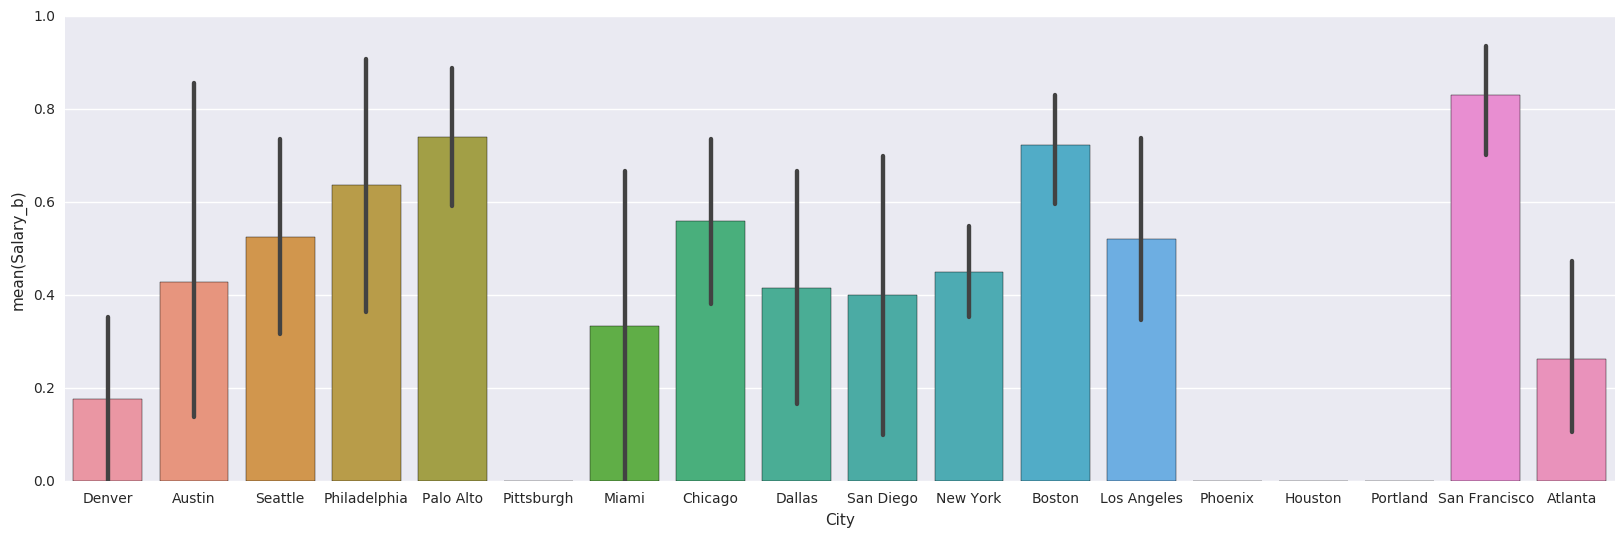

In [214]:
fig = plt.figure(figsize=(20,6)) 
sns.barplot(x="City",y="Salary_b",data=aug_features_df,label="City")

In [215]:
aug_features_df = pd.get_dummies(aug_features_df,prefix=None )
aug_features_df.head(10)

Salary_b  City_Atlanta  City_Austin  City_Boston  City_Chicago  \
0         0             0            0            0             0   
1         0             0            0            0             0   
2         0             0            0            0             0   
3         0             0            0            0             0   
4         0             0            0            0             0   
5         0             0            0            0             0   
6         0             0            0            0             0   
7         0             0            0            0             0   
8         0             0            0            0             0   
9         1             0            0            0             0   

   City_Dallas  City_Denver  City_Houston  City_Los Angeles  City_Miami  \
0            0            1             0                 0           0   
1            0            1             0                 0           0   
2            0            1             0                 0           0   
3            0            1             0                 0           0   
4            0            1             0                 0           0   
5            0            1             0                 0           0   
6            0            1             0                 0           0   
7            0            1             0                 0           0   
8            0            1             0                 0           0   
9            0            1             0                 0           0   

        ...        Title_Technician  Title_tech/spclst/crdntr  Skill_Big Data  \
0       ...                       0                         0               0   
1       ...                       0                         0               0   
2       ...                       0                         0               0   
3       ...                       0                         0               0   
4       ...                       0                         0               0   
5       ...                       0                         0               0   
6       ...                       0                         0               0   
7       ...                       0                         0               0   
8       ...                       0                         0               0   
9       ...                       0                         0               0   

   Skill_Business Intelligence  Skill_Deep Learning-NLP  Skill_Full Stack  \
0                            0                        0                 0   
1                            0                        0                 0   
2                            0                        0                 0   
3                            0                        0                 0   
4                            0                        0                 0   
5                            0                        0                 0   
6                            0                        0                 0   
7                            0                        0                 0   
8                            0                        0                 0   
9                            0                        0                 0   

   Skill_Java-C-Linux  Skill_Machine Learning  Skill_Predictive Modeling  \
0                   0                       0                          0   
1                   0                       0                          0   
2                   0                       0                          0   
3                   0                       0                          0   
4                   0                       0                          0   
5                   0                       0                          0   
6                   0                       0                          0   
7                   0                       0                        

In [216]:
aug_features_df.shape

(406, 42)

In [217]:
print "Total Features:", aug_features_df.columns

Total Features: Index([u'Salary_b', u'City_Atlanta', u'City_Austin', u'City_Boston',
       u'City_Chicago', u'City_Dallas', u'City_Denver', u'City_Houston',
       u'City_Los Angeles', u'City_Miami', u'City_New York', u'City_Palo Alto',
       u'City_Philadelphia', u'City_Phoenix', u'City_Pittsburgh',
       u'City_Portland', u'City_San Diego', u'City_San Francisco',
       u'City_Seattle', u'Title_Analyst', u'Title_Data Engineer',
       u'Title_Data Scientist', u'Title_Dev Ops', u'Title_Engineer',
       u'Title_Executive', u'Title_Junior', u'Title_Manager', u'Title_Misc',
       u'Title_Office', u'Title_Senior', u'Title_Software Engineer',
       u'Title_Statistician', u'Title_Technician', u'Title_tech/spclst/crdntr',
       u'Skill_Big Data', u'Skill_Business Intelligence',
       u'Skill_Deep Learning-NLP', u'Skill_Full Stack', u'Skill_Java-C-Linux',
       u'Skill_Machine Learning', u'Skill_Predictive Modeling',
       u'Skill_Python-R'],
      dtype='object')


In [218]:
y = aug_features_df["Salary_b"]
X = aug_features_df.drop("Salary_b",axis=1)

In [219]:
print  y.values

[0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 0
 0 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1
 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 0 0 1
 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1 1 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 0 0 0 0 1 1 1 0
 0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0
 1 1 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 1 0 1 1 0 1 0
 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1
 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0]


In [220]:
from sklearn import linear_model
#from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,Lasso
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

**In the MODEL below, I seek to leverage sklearn:

1. I seek to split the data in a train and test data set (0.33), 
2. Standardize all features, 
3. Fit the train feature set and 
4. Perform standadization by centering and scaling (i.e. transform). Scaling the data improves the accuracy and is also necessary for proper regularization and parameter tuning. 
5. Then create a Logistic Regression with l1 i.e. Lasso penalty with strong regualrization 
6. Evalute the score.
7. Review the coefficients and identify salient features
8. Create a mapping of coefficient and features
9. Write analysis on my finding
10. Predict the probability and y
11. Create a Data Frame for High/Low salary, y Actual and y Predicted.
12. Get the accuracy score from sklearn
13. Compare the baseline score to accuracy score from sklearn. 
14. Create a confusion matrix.
15. Print a classification report 
16. Provide future recommendations.



In [221]:
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.33, random_state=42)

scaler = StandardScaler()

In [222]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((272, 41), (134, 41), (272,), (134,))

In [223]:
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model = linear_model.LogisticRegression(penalty = 'l1', C=1)
model.fit(X_train, y_train)

train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

#sns.regplot(y_test,model.predict(X_test) )

In [224]:
train_score,test_score

(0.79411764705882348, 0.78358208955223885)

** The train and test score in this model i.e. Lasso with C=1.0 are really good compare to Ridge penalty i.e. l1. This score suggest the mean accuracy of out model is really good for both train as well as test data.**

** Let's now review coefficients for the selected features and see which ones have higher coef_ values that will help us predict the salary better. ** 

In [225]:
feature_coef = []
for i,k in enumerate(X.columns):
    feature_coef.append([k, model.coef_[0][i]])
df_coef=pd.DataFrame(feature_coef)
df_coef.columns = ["feature","coef_"]
print "Positive top 13 coef_: ", df_coef.sort_values(["coef_"],ascending=False).head(13)
print "Negative top 10 coef_: ", df_coef.sort_values(["coef_"]).head(10)

Positive top 13 coef_:                          feature     coef_
34  Skill_Business Intelligence  0.723362
16           City_San Francisco  0.534885
2                   City_Boston  0.509778
39    Skill_Predictive Modeling  0.448436
40               Skill_Python-R  0.399371
20         Title_Data Scientist  0.353068
23              Title_Executive  0.223639
28                 Title_Senior  0.207803
36             Skill_Full Stack  0.200008
22               Title_Engineer  0.162699
37           Skill_Java-C-Linux  0.156813
35      Skill_Deep Learning-NLP  0.155844
7              City_Los Angeles  0.149585
Negative top 10 coef_:                       feature     coef_
32  Title_tech/spclst/crdntr -0.698705
18             Title_Analyst -0.490916
13           City_Pittsburgh -0.436439
6               City_Houston -0.377586
30        Title_Statistician -0.345143
31          Title_Technician -0.269976
26                Title_Misc -0.266688
5                City_Denver -0.246889
14           

Higher  coefficient values help predict **higher salary** classification and lowest/negative coefficient valueshelp predict ** lower salary** classification.

It appears (based on coef_ values) **important features based on skills** are 
1) Business Intelligence skills, 2) Predictive Modeling, 3) Python-R 4) Full Stack, 5) Java 6) Deep Learning where as Machine learning has less significant coefficient.

**important features based on job titles** are  
1) Data Scientist, 2) Senior, 3) Engineer, and 4) Executives

** important features based on location** are
1) City of San Fransico, City of Boston, City of Palo Alto and City of Chicago

Where as title such as **technician, coordinator, analyst and misc will result in classifying low salary. City of Houston, Pittsburgh, Denver and Atlanta will most likely classify in the low salary cateogry.**

**Predict the prability and y for all features and then compare agains actual and then verify the accuracy score. Our Baseline Accuracy score is: 48.52% **

In [226]:
probs = model.predict_proba(X)
probs[:5]

array([[ 0.65013928,  0.34986072],
       [ 0.65013928,  0.34986072],
       [ 0.48037017,  0.51962983],
       [ 0.51667011,  0.48332989],
       [ 0.63209083,  0.36790917]])

In [227]:
predicted = model.predict(X)
predicted[:5]

array([0, 0, 1, 0, 0])

In [228]:
sal_preds = pd.DataFrame({
        'y_true':y,
        'y_hat':predicted,
        'High Sal':probs[:, 1],
        'Low Sal':probs[:, 0]
    })

sal_preds.head(10)

High Sal   Low Sal  y_hat  y_true
0  0.349861  0.650139      0       0
1  0.349861  0.650139      0       0
2  0.519630  0.480370      1       0
3  0.483330  0.516670      0       0
4  0.367909  0.632091      0       0
5  0.519630  0.480370      1       0
6  0.349861  0.650139      0       0
7  0.349861  0.650139      0       0
8  0.431801  0.568199      0       0
9  0.519630  0.480370      1       1

In [229]:
predicted

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1,

In [230]:
print metrics.accuracy_score(y_true=y, y_pred=predicted)

0.768472906404


##  We have a really good accuracy score and that is higher than baseline accuracy. The Baselin Accuracy is 48.52% : and Accuracy score is 76.85%. This suggest the model predicts high/low salary with the accuracy of 76.85%

#### Calculating the confusion matrix metrics for the model below and comparing that with sklearn confusion matrix

In [231]:
tp = np.sum((y == 1) & (predicted == 1))
fp = np.sum((y == 0) & (predicted == 1))
tn = np.sum((y == 0) & (predicted == 0))
fn = np.sum((y == 1) & (predicted == 0))
print tp, fp, tn, fn

181 66 131 28


In [232]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y, predicted)

array([[131,  66],
       [ 28, 181]])

In [233]:
from sklearn.metrics import classification_report

print classification_report(y, predicted)

             precision    recall  f1-score   support

          0       0.82      0.66      0.74       197
          1       0.73      0.87      0.79       209

avg / total       0.78      0.77      0.77       406



##  Conclusion/Recommendation: Alghough the accuracy score is much higher than the baseline accuracy it has potential to improve even higher. May be addiing some feature from summary or external data may help improve better prediction.  